<a href="https://colab.research.google.com/github/hstorm/DETECT_lecture_ML_2022/blob/main/ex_detect_seminar_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DETECT Seminar Machine Learning

In this notebook, you will learn how to solve a simple remote sensing classification task using a Convoloutional Neural Network. To build and train the CNN, we will use the Pytorch library. Your task is to understand what's going on and to modify the notbok, whereever you find a `#TODO`. If you want to save the changes you made to your notebook, you must make a copy on your Google Drive.

## Installing Torchgeo

Most of the libraries we need are pre-installed in the Colab runtime. The only library we need to manually install is Torchgeo, which is a library for datasets, transforms, and models specifically for geospatial data.

In [ ]:
!pip install torchgeo

## Imports

In [ ]:
import os
from tqdm import tqdm

import numpy as np
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T

from torchgeo.datasets import EuroSAT

## Check if a GPU is available.
Training neural networks requires lots of computations, which is why it takes a long time to train them on a CPU. Fortunately, the computations are highly parallelizable, which is why we can use a GPU instead. This cell will return `cuda:0` if a GPU is available for computations. It it doesn't, go to Runtime > Change runtime type and select 'GPU' as your hardware accelerator.

In [ ]:
 device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
 print(device)

cuda:0


## Transforms
Here, we will define transforms, which we will apply to any sample that is loaded from the dataset. Particularly, we will normalize the image data, which one should always do. We will also reduce the number of classes to reduce the training time.

In [ ]:
class Transform(nn.Module):

  def __init__(self, 
    # The defaults for min and max are referencevalues for Sentinel-2
    mins = [1013.0, 676.0, 448.0, 247.0, 269.0, 253.0, 243.0, 189.0, 61.0, 4.0, 33.0, 11.0, 186.0], 
    maxs = [2309.0, 4543.05, 4720.2, 5293.05, 3902.05, 4473.0, 5447.0, 5948.05, 1829.0, 23.0, 4894.05, 4076.05, 5846.0]
  ):

    super().__init__()
    self.mins = torch.tensor(mins)[:, None, None]
    self.maxs = torch.tensor(maxs)[:, None, None]

  def forward(self, samples):

    samples['image'] = ((samples['image'] - self.mins) / (self.maxs - self.mins)).float()
    y = samples['label'].item()
    
    if y in [3, 4, 7]:
      samples['label'] = F.one_hot(torch.tensor(0), num_classes = 4).float()
    elif y in [0, 5, 6]:
      samples['label'] = F.one_hot(torch.tensor(1), num_classes = 4).float()
    elif y in [1, 2]:
      samples['label'] = F.one_hot(torch.tensor(2), num_classes = 4).float()
    elif y in [8, 9]:
      samples['label'] = F.one_hot(torch.tensor(3), num_classes = 4).float()

    return samples


new_classes = ['Urban', 'Agriculture', 'Natural', 'Water']

## Download the EuroSAT Datatset
The EuroSAT dataset consists of 27000 labeled Sensinel-2 images. Sentinel-2 is a multispectral satellite, with 13 spectral bands (see the image below). In the original dataset, there are 10 different classes, which we aggregate into 4 in the transform class: \
\
Highway, Industrial, Residential --> Urban \
Annual Crop, Pasture, Permanent Crop --> Agriculture \
Forest, Herbaceous Vegetation --> Natural \
River, Sea/Lake --> Water \
\
The split of the dataset into training, validation and testing subset is predefined and we load them as three different datasets. We will have a look at how many samples there are in each of the subsets.

![](https://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

Paper: P. Helber, B. Bischke, A. Dengel and D. Borth, "EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification," in IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, vol. 12, no. 7, pp. 2217-2226, July 2019

In [ ]:
# Download datasets
ds_train = EuroSAT(root='train', split='train', transforms=Transform(), download=True)
ds_test = EuroSAT(root='test', split='test', transforms=Transform(), download=True)

print('Number of images in training dataset:', len(ds_train))
print('Number of images in testing dataset:', len(ds_test))

  0%|          | 0/2067725275 [00:00<?, ?it/s]

  0%|          | 0/313605 [00:00<?, ?it/s]

  0%|          | 0/104659 [00:00<?, ?it/s]

  0%|          | 0/104163 [00:00<?, ?it/s]

  0%|          | 0/2067725275 [00:00<?, ?it/s]

  0%|          | 0/313605 [00:00<?, ?it/s]

  0%|          | 0/104659 [00:00<?, ?it/s]

  0%|          | 0/104163 [00:00<?, ?it/s]

Number of images in training dataset: 16200
Number of images in testing dataset: 5400


## Initialize Dataloaders
As the name suggests, dataloaders serve the purpose of loading data from the dataset and turn them into torch tensors -- the datastructure required by the Pytorch library -- for subsequent usage in the model. We initialize the dataloader on the training dataset and with a batch size, i.e. the number of samples which are loaded and passed through the network at once.

In [ ]:
# Initialize data loaders
dl_train = DataLoader(
    ds_train, 
    batch_size=100, #TODO
    shuffle=True
)

dl_test = DataLoader(ds_test, batch_size=5400, shuffle=False)

## Inspect the training dataset
Select an image index with the slider and choose which band to show in which channel in the dropdown menus. For example, choose (B4, B3, B2) for the regular R-G-B view and (B8, B4, B3) for the NIR-R-G view. \
Think about what kind of features are indicative of each class. Why are CNNs possibly better suited for this classification task than regular neural networks?

Class Label: Agriculture


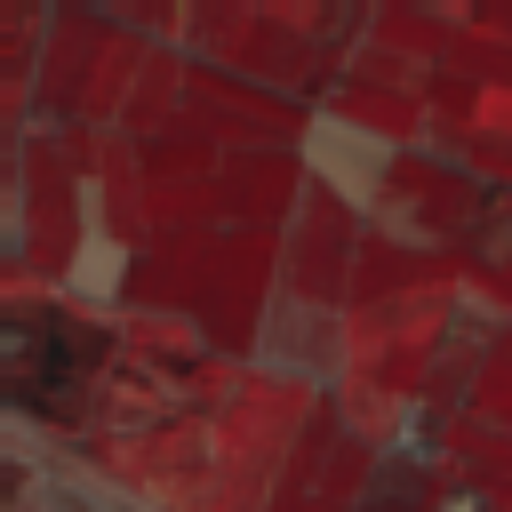

In [ ]:
# Select bands to show: RGB is [3,2,1], NIR-R-G is [7,3,2]


#@title EuroSat Multispectral Browser  { run: "auto", vertical-output: true }
idx = 10001 #@param {type:"slider", min:0, max:16199, step:1}
channels = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "B9", "B10", "B11", "B12"]
red_channel = 'B8' #@param ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "B9", "B10", "B11", "B12"] {allow-input: true}
green_channel = 'B4' #@param ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "B9", "B10", "B11", "B12"] {allow-input: true}
blue_channel = 'B3' #@param ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "B9", "B10", "B11", "B12"] {allow-input: true}
band_dict = {'B1':0, 'B2':1, 'B3':2, 'B4':3, 'B5':4, 'B6':5, 'B7':6, 'B8':7, 'B8a':8, 'B9':9, 'B10':10, 'B11':11, "B12":12}
band_idx = [band_dict[red_channel], band_dict[green_channel], band_dict[blue_channel]]
sample = ds_train[idx]
bands = sample["image"][band_idx]
image = T.ToPILImage()(bands)
label = torch.argmax(sample['label'], dim=-1)
print('Class Label:', new_classes[label])
image.resize((512, 512), resample=Image.BILINEAR)

## Initialize the CNN and specify the architecture
This is the part, where you can define the layers of your CNN in the constructor (`def __init__(self):`). Right now, it is a pretty small and poorly designed model, so it is now your task to modify it and make it better. These are some of the layers you could use. Note that you always start with a [13, 64, 64] image and want to end up with a 4-dimensional class vector.

*   Convolutional layer `torch.nn.Conv2d`: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
*   Pooling layer `torch.nn.MaxPool2d`: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool2d#torch.nn.MaxPool2d
*   Linear layer `torch.nn.Linear`: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear
*   Batch Normalization layers `torch.nn.BatchNorm1d`: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d and `torch.nn.BatchNorm2d`: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d
*   Activation function `torch.nn.ReLU`: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
*   Flattening (Collapsing the tensor into one dimension) `torch.nn.Flatten()`: https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten
*   Dropout layer `torch.nn.Dropout`: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
*   Softmax output `torch.nn.Softmax`: https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax


But, of course, feel free to try any layers or activation functions you want from `torch.nn`: https://pytorch.org/docs/stable/nn.html



In [ ]:
class CNN(nn.Module):

  def __init__(self):
    
    super().__init__() 
    
    self.layers = nn.Sequential(
        
      #TODO
        
      nn.Conv2d(in_channels=13, out_channels=64, kernel_size=3, padding=1),
      nn.MaxPool2d(kernel_size=8),
      nn.ReLU(),

      nn.Flatten(),

      nn.Linear(in_features=4096, out_features=4),
      nn.Softmax(dim=1)

    )

  def forward(self, x):

    return self.layers(x)

## Initialize CNN, an optimizer and define a loss function
We initialize the model as defined above. The optimizer will take care of the application of the gradients. Once again, you have multiple different options to choose from (https://pytorch.org/docs/stable/optim.html). Here, we select Stochastic Gradient Descent. The optimizer is initialized with a learning rate and a weight decay, which applies L2-regularization to the weights. Feel free to change these, if you like.

In [ ]:
cnn = CNN().to(device)

optimizer = optim.SGD(
    cnn.parameters(), 
    lr=1e-2, #TODO
    weight_decay=1e-2 #TODO
)

loss_function = nn.CrossEntropyLoss()

## Train
Now we are set to finally train the model. We define a number of epochs. In each epoch we will pass the training set through the model using the defined batch size. After each iteration, we adjust the weights accordingly. This may take up to more than one minute per epoch.

In [ ]:
n_epochs = 10
loss_log = []

for _ in tqdm(range(n_epochs)):

  running_loss = 0

  # Train

  for i, batch in enumerate(dl_train):

    x = batch['image'].to(device) # Send tensors to the GPU
    y = batch['label'].to(device)

    optimizer.zero_grad() # set gradients to zero
    y_hat = cnn(x) # Apply model to current batch
    loss = loss_function(y_hat, y) # Compute loss
    loss.backward() # Calculate gradients
    optimizer.step() # Apply gradients

    running_loss += loss.item()

  loss_log.append(running_loss / (i+1))

100%|██████████| 10/10 [09:07<00:00, 54.75s/it]


## Visualize the loss function
Let's see how the loss develops over time. We are trying to minimze this loss so it should decrease. It you train for a sufficient ammount of epochs, the loss eventually saturates, which indicates that the network has converged to a local minimum.

Text(0, 0.5, 'Validation Loss')

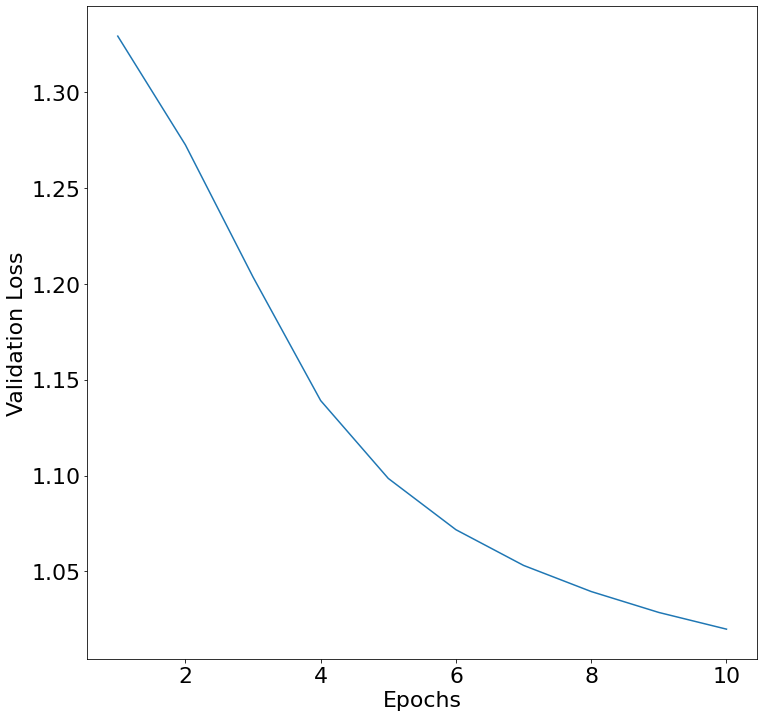

In [ ]:
plt.rcParams.update({'figure.figsize': (12, 12)})
plt.rcParams.update({'font.size': 22})

plt.plot(np.arange(n_epochs) + 1, np.array(loss_log))
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

## Evaluate
Let's finally apply the model to the testing dataset and see how it performs by looking at the confusion matrix. Which class is easiest to distinguish from the others? Why do you think that could be?

OVERALL ACCURACY: 0.7574074074074074


Text(77.0, 0.5, 'ACTUAL CLASSES')

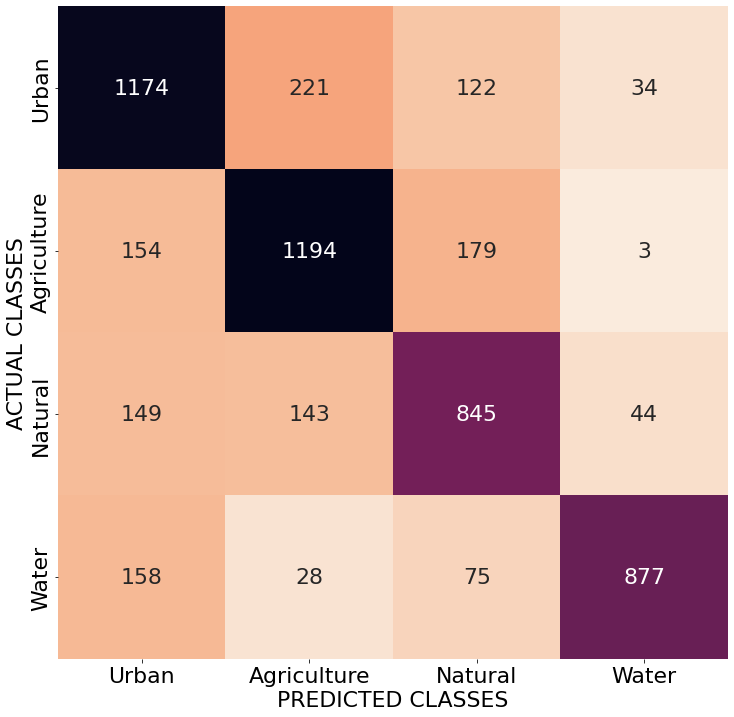

In [ ]:
# Test/Evaluate

cnn.eval()

x = next(iter(dl_test))['image']
y = next(iter(dl_test))['label']

with torch.no_grad():
  y_hat = cnn(x.to(device)).cpu()

y = torch.argmax(y, dim=-1)
y_hat = torch.argmax(y_hat, dim=-1)

cm = confusion_matrix(y, y_hat)
 
print('OVERALL ACCURACY:', np.sum(np.diag(cm)) / np.sum(cm))

ax = sns.heatmap(cm, annot=True, fmt = "d", cmap="rocket_r", xticklabels=new_classes, yticklabels=new_classes, cbar=False)
ax.set_xlabel('PREDICTED CLASSES')
ax.set_ylabel('ACTUAL CLASSES') 